# Andrew Yang's Freedom Dividend: Find revenue-neutral parameters

Estimate the effect of Andrew Yang's [Freedom Dividend](https://www.yang2020.com/policies/the-freedom-dividend/) of $12,000 per year per adult over age 18, funded by a 10 percent [value-added tax](https://www.yang2020.com/policies/value-added-tax/) and reducing benefits by up to the UBI amount for each tax unit.

Assumptions:
* Adults are 18+ not 19+, for data availability.
* Benefits include SNAP, WIC, SSI, TANF, WIC, Social Security, and unemployment insurance. Per Yang's [tweet](https://twitter.com/AndrewYang/status/970104619832659968), it excludes housing benefits and Medicare. It also excludes Medicaid, veteran's benefits (which are largely pension and healthcare) and "other benefits" included in C-TAM, which also include some healthcare.
* VAT incidence is proportional to [Tax Policy Center's estimate](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat) of a 5 percent VAT's effect as of 2015. These are scaled linearly to match Yang's estimate that his VAT would raise $800 billion per year.
* VAT incidence is treated as an income tax; per TPC:
>Conceptually, the tax can either raise the total price (inclusive of the sales tax) paid by consumers or reduce the amount of business revenue available to compensate workers and investors. Theory and evidence suggest that the VAT is passed along to consumers via higher prices. Either way, the decline in real household income is the same regardless of whether prices rise (holding nominal incomes constant) or whether nominal incomes fall (holding the price level constant).

*Data: CPS  |  Tax year: 2019  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'2.2.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

GRID_COLOR = '#eeeeee'  # Previously lighter #f5f5f5.

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

In [6]:
np.random.seed(0)

## Major parameters

In [7]:
UBI = 1000 * 12
TOTAL_VAT = 800e9
TOTAL_FTT = 50e9
CARBON_FEE = 40
CARBON_FEE_TPC = 49  # Fee from the paper.
CARBON_FEE_UBI_SHARE = 0.5  # Half goes to UBI, half to other projects.
PCT_CITIZEN = 0.93
# Yang's plan wouldn't be enacted until 2021, but 
# this allows people to enter current income.
YEAR = 2019

## Data

In [8]:
recs = tc.Records.cps_constructor()

In [9]:
BENS = ['snap_ben', 'ssi_ben', 'tanf_ben', 'wic_ben',
        'e02400',  # Social Security (OASDI).
        'e02300'  # Unemployment insurance.
       ]

# Exclude health from aftertax_income.
SUBTRACT_VARS = ['mcaid_ben', 'mcare_ben']

In [10]:
base0 = tch.calc_df(records=recs, year=YEAR,
                    group_vars=['nu18', 'n1820', 'n21', 'aftertax_income'] + 
                    BENS + SUBTRACT_VARS + tch.ECI_REMOVE_COLS,
                    metric_vars=['expanded_income', 'XTOT'])

Duplicate records to make citizens and noncitizens.

In [11]:
base_citizen = base0.copy(deep=True)
base_citizen['citizen'] = True
base_citizen.s006 *= PCT_CITIZEN

base_noncitizen = base0.copy(deep=True)
base_noncitizen['citizen'] = False
base_noncitizen.s006 *= 1 - PCT_CITIZEN

base = pd.concat([base_citizen, base_noncitizen])

Reset index since `RECID` is no longer unique.

In [12]:
base.reset_index(inplace=True)

In [13]:
base['afti'] = base.aftertax_income - base[SUBTRACT_VARS].sum(axis=1)
tch.add_weighted_metrics(base, ['afti'])
base['tpc_eci'] = tch.tpc_eci(base)
tch.add_weighted_quantiles(base, 'tpc_eci')

### Calculations

In [14]:
base['bens'] = base[BENS].sum(axis=1)
base['adults'] = base.n1820 + base.n21
base['adult_citizens'] = base.adults * base.citizen

### Revenue-neutral

In [24]:
def yang_shortfall(ubi=UBI, bens=BENS, data=base):
    base = data.copy(deep=True)
    base['bens'] = base[bens].sum(axis=1)
    base['ubi_max'] = base.adult_citizens * ubi
    # Tax units take the UBI if it exceeds benefits.
    base['ubi'] = np.where(base.ubi_max > base.bens, base.ubi_max, 0)
    # Tax units that take the UBI decline benefits.
    base['bens_yang'] = np.where(base.ubi > 0, 0, base.bens)
    base['bens_cut'] = base.bens - base.bens_yang
    # Weight
    base['ubi_m'] = base.ubi * base.s006 / 1e6
    base['ubi_max_m'] = base.ubi_max * base.s006 / 1e6
    base['bens_m'] = base.bens * base.s006 / 1e6
    base['bens_yang_m'] = base.bens_yang * base.s006 / 1e6
    base['bens_cut_m'] = base.bens_cut * base.s006 / 1e6
    # New taxes
    base['afti_yang_pre_new_taxes'] = base.aftertax_income + base.ubi - base.bens_cut
    base['afti_yang_pre_new_taxes_noneg'] = base.afti_yang_pre_new_taxes.clip_lower(0)
    tch.add_weighted_quantiles(base, 'afti_yang_pre_new_taxes_noneg')
    tch.add_vat(base, total=TOTAL_VAT)
    tch.add_carbon_tax(base, ratio=CARBON_FEE / CARBON_FEE_TPC)
    tch.add_ftt(base, total=TOTAL_FTT)
    base['new_taxes'] = base[['vat', 'carbon_tax', 'ftt']].sum(axis=1)
    base['vat_m'] = tch.weight(base, 'vat') / 1e6
    base['ftt_m'] = tch.weight(base, 'ftt') / 1e6
    base['new_taxes_m'] = tch.weight(base, 'new_taxes') / 1e6
    base['afti_yang_pre_new_taxes_noneg_m'] = tch.weight(base, 'afti_yang_pre_new_taxes_noneg') / 1e6
    base['afti_yang'] = base.afti_yang_pre_new_taxes - base.vat - base.ftt - base.carbon_tax
    base['afti_chg'] = base.afti_yang - base.aftertax_income
    base['afti_chg_m'] = base.afti_chg * base.s006 / 1e6
    shortfall_m = (base.afti_chg_m.sum() + 
                   CARBON_FEE_UBI_SHARE * tch.weighted_sum(base, 'carbon_tax') / 1e6)
    return shortfall_m * 1e6

In [25]:
def shortfall_by_ubi(ubi=UBI, bens=BENS, data=base):
    return pd.DataFrame({'ubi': [ubi],
                         'bens': ','.join(bens),
                         'shortfall': [yang_shortfall(ubi, bens, data)]})

In [26]:
shortfalls_l = []
for i in np.arange(0, UBI+1, 120):
    print('Calculating UBI of $' + str(int(i / 12)) + ' per month...')
    shortfalls_l.append(shortfall_by_ubi(ubi=i))
    shortfalls_l.append(shortfall_by_ubi(ubi=i, bens=[]))
shortfalls = pd.concat(shortfalls_l).drop_duplicates()

Calculating UBI of $0 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $10 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $20 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $30 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $40 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $50 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $60 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $70 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $80 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $90 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $100 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $110 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $120 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $130 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $140 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $150 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $160 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $170 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $180 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $190 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $200 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $210 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $220 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $230 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $240 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $250 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $260 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $270 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $280 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $290 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $300 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $310 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $320 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $330 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $340 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $350 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $360 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $370 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $380 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $390 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $400 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $410 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $420 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $430 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $440 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $450 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $460 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $470 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $480 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $490 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $500 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $510 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $520 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $530 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $540 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $550 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $560 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $570 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $580 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $590 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $600 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $610 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $620 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $630 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $640 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $650 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $660 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $670 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $680 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $690 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $700 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $710 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $720 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $730 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $740 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $750 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $760 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $770 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $780 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $790 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $800 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $810 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $820 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $830 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $840 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $850 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $860 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $870 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $880 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $890 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $900 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $910 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $920 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $930 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $940 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $950 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $960 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $970 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $980 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $990 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.
Calculating UBI of $1000 per month...


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Multiplying tax by 1.91.
Multiplying tax by 1.61.


In [27]:
shortfalls['abs_shortfall'] = np.abs(shortfalls.shortfall)
shortfalls['ubi_monthly'] = shortfalls.ubi / 12

In [28]:
shortfalls_ben = shortfalls[shortfalls.bens > '']
shortfalls_noben = shortfalls[shortfalls.bens == '']

In [29]:
rn_ubi_ben = shortfalls_ben.sort_values('abs_shortfall').iloc[0].ubi_monthly
('The stated tax parameters could fund a UBI of ${:} per month.'.format(int(rn_ubi_ben)))

'The stated tax parameters could fund a UBI of $520 per month.'

In [30]:
rn_ubi_noben = shortfalls_noben.sort_values('abs_shortfall').iloc[0].ubi_monthly
('Without replacing benefits, the stated tax parameters could fund a UBI of ' +
 '${:} per month.'.format(int(rn_ubi_noben)))

'Without replacing benefits, the stated tax parameters could fund a UBI of $340 per month.'

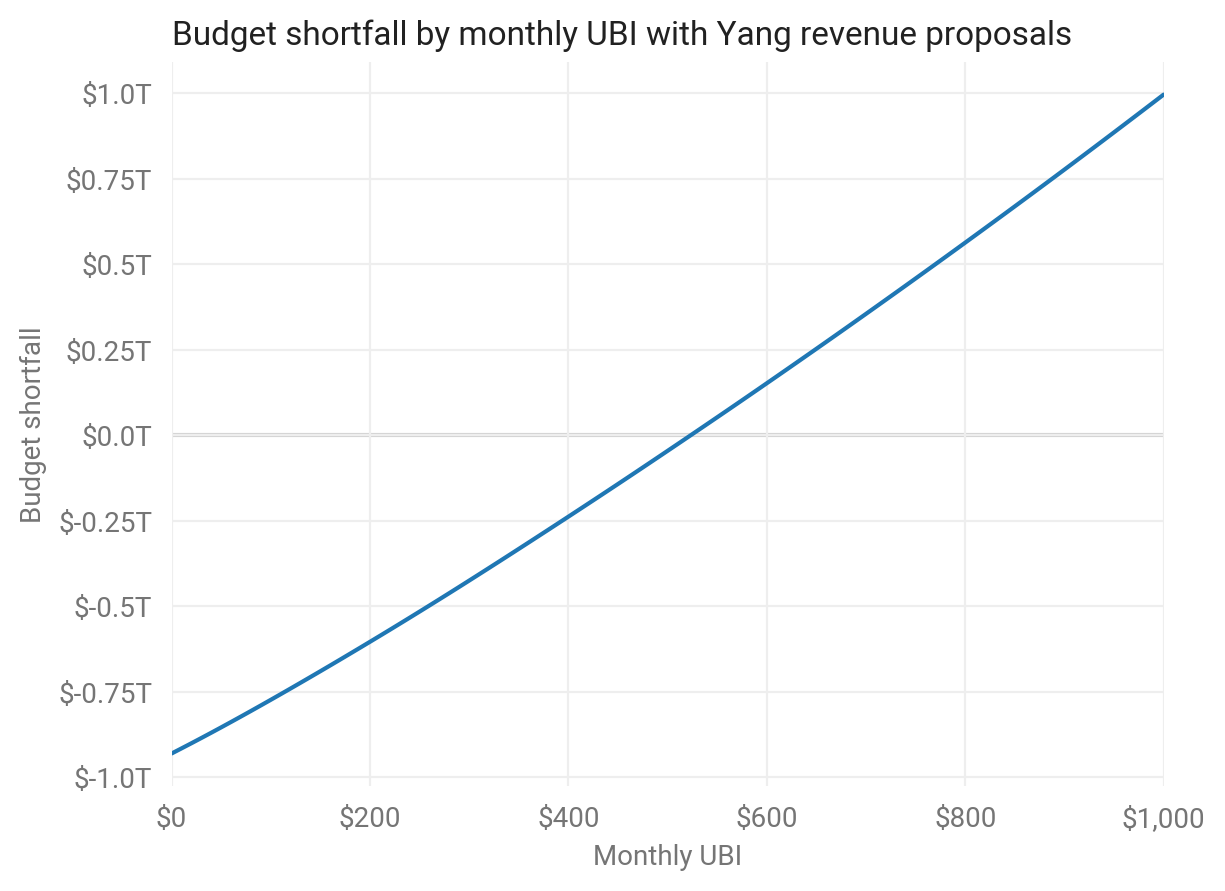

In [31]:
ax = shortfalls_ben.sort_values('ubi').plot('ubi_monthly', 'shortfall')
plt.title('Budget shortfall by monthly UBI with Yang revenue proposals', loc='left')
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(x / 1e12) + 'T'))
ax.grid(color=GRID_COLOR)
ax.legend_.remove()
ax.axhline(0, color='lightgray', zorder=-1)
plt.xlabel('Monthly UBI')
plt.ylabel('Budget shortfall')
plt.show()

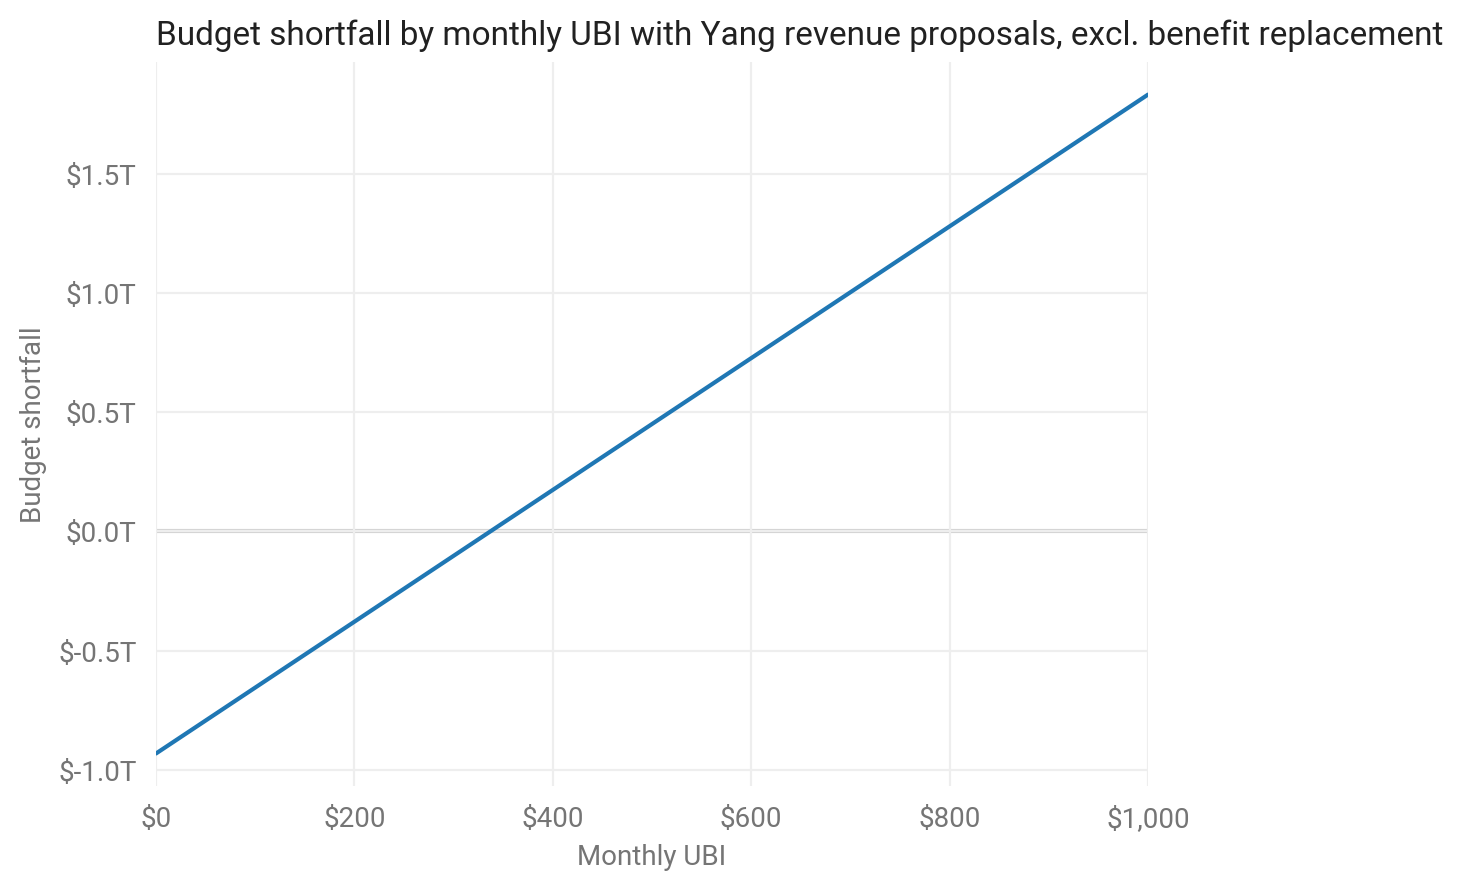

In [32]:
ax = shortfalls_noben.sort_values('ubi').plot('ubi_monthly', 'shortfall')
plt.title('Budget shortfall by monthly UBI with Yang revenue proposals, excl. benefit replacement', loc='left')
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(x / 1e12) + 'T'))
ax.grid(color=GRID_COLOR)
ax.legend_.remove()
ax.axhline(0, color='lightgray', zorder=-1)
plt.xlabel('Monthly UBI')
plt.ylabel('Budget shortfall')
plt.show()

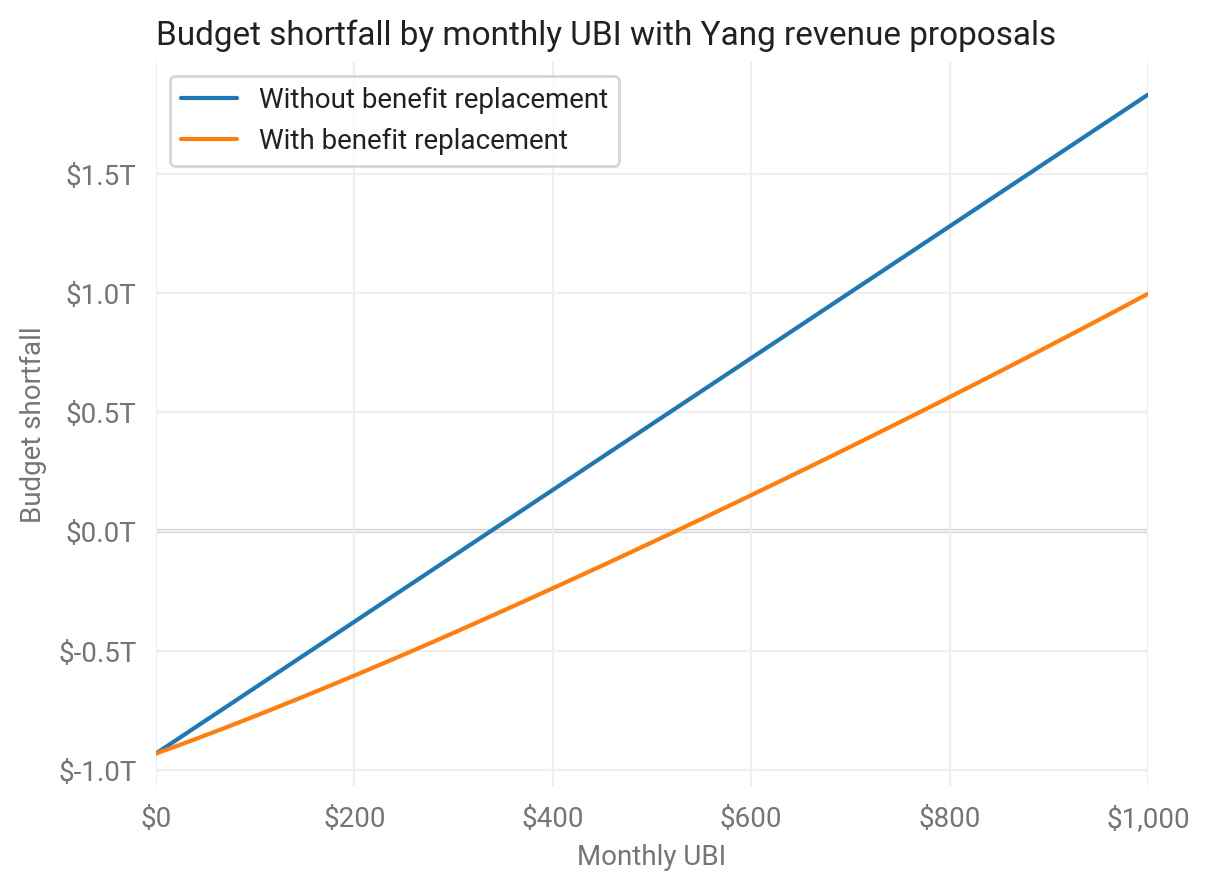

In [33]:
ax = shortfalls_noben.sort_values('ubi').plot('ubi_monthly', 'shortfall')
shortfalls_ben.sort_values('ubi').plot('ubi_monthly', 'shortfall', ax=ax)
plt.title('Budget shortfall by monthly UBI with Yang revenue proposals', loc='left')
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(x / 1e12) + 'T'))
ax.grid(color=GRID_COLOR)
ax.legend(['Without benefit replacement', 'With benefit replacement'])
ax.axhline(0, color='lightgray', zorder=-1)
plt.xlabel('Monthly UBI')
plt.ylabel('Budget shortfall')
plt.show()